In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
# from qolmat.diffusion_model  import ImputerDiffusion
# from qolmat.model import TabDDPM, TsDDPM
from diffusion import DDPM

In [2]:
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
print(device)

cuda:0


## Load Data

In [4]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [5]:
data = aggregate_market_data()

df_reindexed, df_orig, df = prepare_data(data, from_year = from_year, start_year_test = None)

100%|██████████| 141/141 [00:00<00:00, 162.47it/s]


### Preprocess Data

In [6]:
train_df = df_reindexed#.loc[:'2019']
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
print(X_train.shape)

torch.Size([6390, 53])


## Hyperparameters

In [7]:
# hyperparameters

# diffusion hyperparameters
timesteps = 50
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 30
hidden_dim = 32
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 64
n_epoch = 50
lrate=1e-3

## DDPM

### Models

In [8]:
#model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

In [9]:
from models import AutoEncoder, ResidualBlockTS
model = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = n_feat ,
                    residual_block = ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding = hidden_dim,
                    dim_output = n_feat,
).to(device)

In [10]:
# model_qolmat = TsDDPM(num_noise_steps=50,nheads_feature=8,nheads_time=8)

### Training

In [11]:
train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model.parameters(), lr=lrate)

/users/eleves-b/2022/haocheng.liu/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
ddpm = DDPM(model = model, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

In [13]:
losses, maes, wasserstein_distances =ddpm.train(train_loader=train_loader)

epoch 0


100%|██████████| 100/100 [00:03<00:00, 25.68it/s]


Loss: 1.5653879074379802, MAE: 1.2477776408195496, Wasserstein Distance: 1.1435692955481986
epoch 1


100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


epoch 2


100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


epoch 3


100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


epoch 4


100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Loss: 1.4990319134667516, MAE: 1.2200380768626928, Wasserstein Distance: 1.052976443142739
epoch 5


100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


epoch 6


100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


epoch 7


100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


epoch 8


100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Loss: 1.4741413854062557, MAE: 1.208337522111833, Wasserstein Distance: 1.0257679469766936
epoch 9


100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


epoch 10


100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


epoch 11


100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


epoch 12


100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Loss: 1.4614193988963962, MAE: 1.2025237530469894, Wasserstein Distance: 1.013209547739717
epoch 13


100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


epoch 14


100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


epoch 15


100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


epoch 16


100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


Loss: 1.4567097360268235, MAE: 1.2005031695589423, Wasserstein Distance: 1.0123797563907457
epoch 17


100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


epoch 18


100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


epoch 19


100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


epoch 20


100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Loss: 1.4553628033027053, MAE: 1.199435698799789, Wasserstein Distance: 1.0106841386767105
epoch 21


100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


epoch 22


100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


epoch 23


100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


epoch 24


100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Loss: 1.4537956211715937, MAE: 1.19899342674762, Wasserstein Distance: 1.012644206269947
epoch 25


100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


epoch 26


100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


epoch 27


100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


epoch 28


100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Loss: 1.4482175223529339, MAE: 1.196150742471218, Wasserstein Distance: 1.006174711733941
epoch 29


100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


epoch 30


100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


epoch 31


100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


epoch 32


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


Loss: 1.4522516708821058, MAE: 1.1980064027011395, Wasserstein Distance: 1.010247001627483
epoch 33


100%|██████████| 100/100 [00:03<00:00, 27.91it/s]


epoch 34


100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


epoch 35


100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


epoch 36


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


Loss: 1.4482675585895777, MAE: 1.1963915713131428, Wasserstein Distance: 1.0062655361719843
epoch 37


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


epoch 38


100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


epoch 39


100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


epoch 40


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Loss: 1.448941226117313, MAE: 1.1964009925723076, Wasserstein Distance: 1.0059970691237277
epoch 41


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


epoch 42


100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


epoch 43


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


epoch 44


100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


Loss: 1.4435962680727243, MAE: 1.1940812710672617, Wasserstein Distance: 1.0002627567885674
epoch 45


100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


epoch 46


100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


epoch 47


100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


epoch 48


100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


Loss: 1.442055736668408, MAE: 1.193580599501729, Wasserstein Distance: 0.9981314060565566
epoch 49


100%|██████████| 100/100 [00:03<00:00, 27.81it/s]

Loss: 1.4456198206171393, MAE: 1.1948480289429426, Wasserstein Distance: 1.003693736471258
saved model at ./weights/model_final.pth


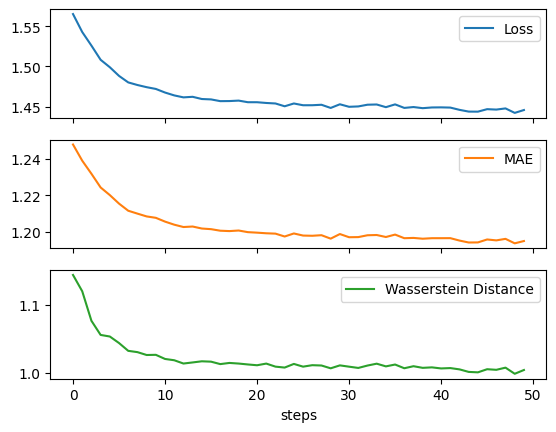

In [14]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

## F-DDPM

epoch 0


100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


Loss: 1.5606429409235716, MAE: 1.245838356204331, Wasserstein Distance: 1.124344355298308
epoch 1


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


epoch 2


100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


epoch 3


100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


epoch 4


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Loss: 1.4637970682233572, MAE: 1.2048264630138874, Wasserstein Distance: 0.9969916049974975
epoch 5


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


epoch 6


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


epoch 7


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


epoch 8


100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


Loss: 1.4430125039070845, MAE: 1.1946569876745343, Wasserstein Distance: 0.986414600625417
epoch 9


100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


epoch 10


100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


epoch 11


100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


epoch 12


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Loss: 1.4285844638943672, MAE: 1.1877398984506726, Wasserstein Distance: 0.9728359895854686
epoch 13


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


epoch 14


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


epoch 15


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


epoch 16


100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Loss: 1.4245218923315406, MAE: 1.1857324847951531, Wasserstein Distance: 0.970308434543664
epoch 17


100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


epoch 18


100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


epoch 19


100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


epoch 20


100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Loss: 1.4196353359147906, MAE: 1.1833550482988358, Wasserstein Distance: 0.9654380641841623
epoch 21


100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


epoch 22


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 23


100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


epoch 24


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Loss: 1.4149921089410782, MAE: 1.1813448630273342, Wasserstein Distance: 0.9636365325528682
epoch 25


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 26


100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


epoch 27


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 28


100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Loss: 1.4085219521075487, MAE: 1.17813431750983, Wasserstein Distance: 0.9589648604518131
epoch 29


100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


epoch 30


100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


epoch 31


100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


epoch 32


100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Loss: 1.413266746327281, MAE: 1.180255051702261, Wasserstein Distance: 0.9635773606334436
epoch 33


100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


epoch 34


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 35


100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


epoch 36


100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Loss: 1.4067169139161706, MAE: 1.177358129993081, Wasserstein Distance: 0.95946498952538
epoch 37


100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


epoch 38


100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


epoch 39


100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


epoch 40


100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Loss: 1.4088159371167421, MAE: 1.1781792240217328, Wasserstein Distance: 0.9584288800493791
epoch 41


100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


epoch 42


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


epoch 43


100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


epoch 44


100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Loss: 1.4075792981311679, MAE: 1.1776245962828398, Wasserstein Distance: 0.959903974047161
epoch 45


100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


epoch 46


100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


epoch 47


100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


epoch 48


100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Loss: 1.4074082411825657, MAE: 1.1774279549717903, Wasserstein Distance: 0.9574225947857966
epoch 49


100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Loss: 1.4093192294239998, MAE: 1.1782595571130514, Wasserstein Distance: 0.9590332666873322
saved model at ./weights/model_final.pth


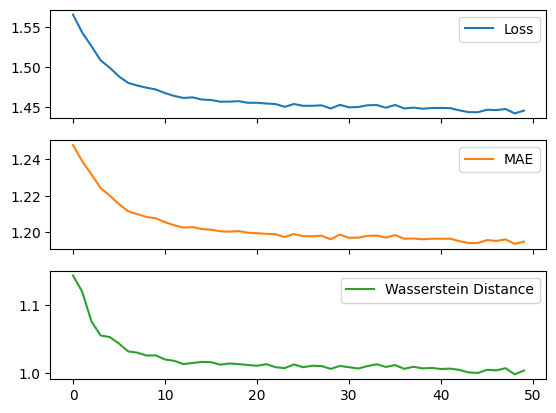

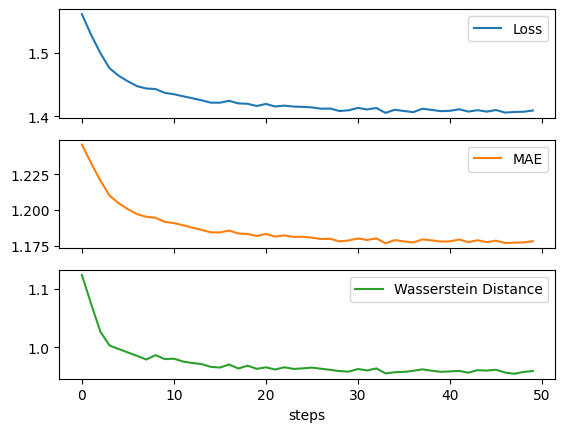

In [21]:
from models import AutoEncoder, ResidualBlockTS
from diffusion import F_DDPM

model_f = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = n_feat ,
                    residual_block = ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding = hidden_dim,
                    dim_output = n_feat ,
).to(device)

train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model_f.parameters(), lr=lrate)

f_ddpm = F_DDPM(model = model_f, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

losses, maes, wasserstein_distances = f_ddpm.train(train_loader=train_loader)

# Convert lists to DataFrame
metrics_fddmp_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot two models metrics
metrics_df.plot(subplots=True)
metrics_fddmp_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

### Training Loss

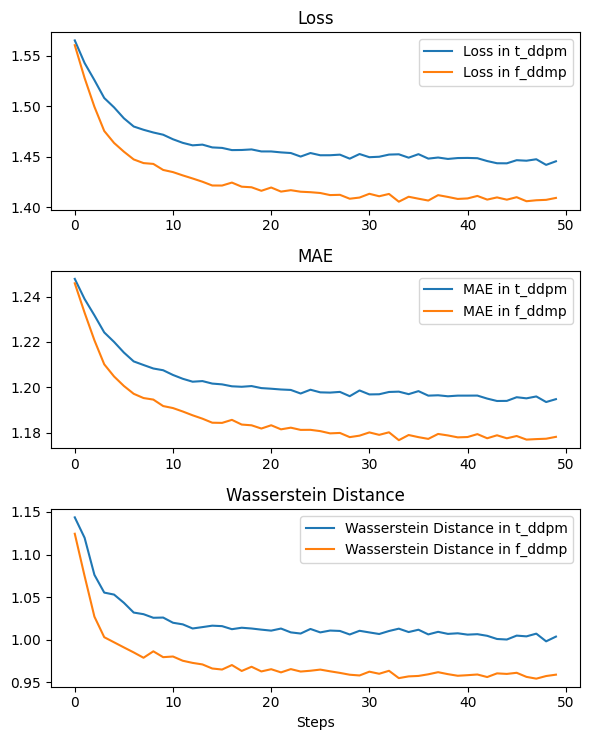

In [22]:
import matplotlib.pyplot as plt

num_plots = len(metrics_df.columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(6, num_plots * 2.5))

if num_plots == 1:
    axes = [axes]

for i, column in enumerate(metrics_df.columns):
    metrics_df[column].plot(ax=axes[i], label=f'{column} in t_ddpm')
    metrics_fddmp_df[column].plot(ax=axes[i], label=f'{column} in f_ddmp')
    axes[i].set_title(column)
    axes[i].legend()

plt.xlabel('Steps')

plt.tight_layout()  
plt.show()

In [26]:
n_sample = X_train.shape[0] // input_size

gen_samples, _  = ddpm.sample(n_sample = n_sample, window_size = input_size, dim_input = n_feat, save_rate=20)

# np.save('samples.npy', gen_samples.cpu())

In [19]:
"""tabddpm = ImputerDiffusion(
    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',
      freq_str = '1B',columnwise=False)"""
#tabddpm.fit(df_reindexed)
#pd.DataFrame(tabddpm.model.summary).plot(subplots=True)
#plt.xlabel('epochs')

"tabddpm = ImputerDiffusion(\n    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',\n      freq_str = '1B',columnwise=False)"

### Evaluation

In [27]:
import json
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data
path_results = os.getcwd() + "/results/DDPM/"
# path_results = os.getcwd() + "\\100\\"
parameters = [d for d in os.listdir(path_results) if os.path.isdir(os.path.join(path_results, d))]
print(parameters)
for param in parameters:
    print(param)
    path_parameters = path_results + param
    var = [d for d in os.listdir(path_parameters) if os.path.isdir(os.path.join(path_parameters, d))]
    print(var)
    train_ratio = 0.8
    results = {}
    for v in var:
        print(v)
        config_results = json.load(open(path_parameters + "/" + v + '/config.json', 'r'))
        #create  samples from df_orig time series
        seq_len = config_results["SEQ_LEN"]
        n_samples = X_train.shape[0] // seq_len
        samples_orig = np.zeros((n_samples, seq_len, n_feat))
        for i in range(n_samples):
            idx = np.random.randint(0, df_orig.shape[0]-seq_len)
            samples_orig[i] = df_orig.iloc[idx:idx+seq_len].values

        gen_samples = np.load(path_parameters + "/" + v + '/samples.npy')[:n_samples]
        eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
        eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
        eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=train_ratio)
        results[v] = eval_results    
    results_df = pd.DataFrame(results).T
    results_df.index = results_df.index.astype(float)
    results_df = results_df.sort_index()
    results_df.index.name = param
    results_df.plot(subplots=True, figsize=(10, 8), linewidth=2, marker='o')
    plt.xticks(results_df.index)
    plt.savefig('./plots/' + param + '_epoch_300_timesteps_100'+'.png')

['SEQ_LEN']
SEQ_LEN
['21']
21
Training LDS model...


/Data/.sys/envs/env0/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 30 but got size 21 for tensor number 1 in the list.

#### Visualisations

In [28]:
df_orig = df_orig['Ret'].unstack().T

In [29]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

In [30]:
synth_data = pd.DataFrame(gen_samples[0,:,:].numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [31]:
from plot_results import plot_data

In [32]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

TypeError: tuple indices must be integers or slices, not str

In [33]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [34]:
true_data = df_orig[start_year_test:]

In [35]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


AttributeError: 'tuple' object has no attribute 'columns'

In [36]:
kl_col.mean().values[0]

NameError: name 'kl_col' is not defined

NameError: name 'kl_col' is not defined

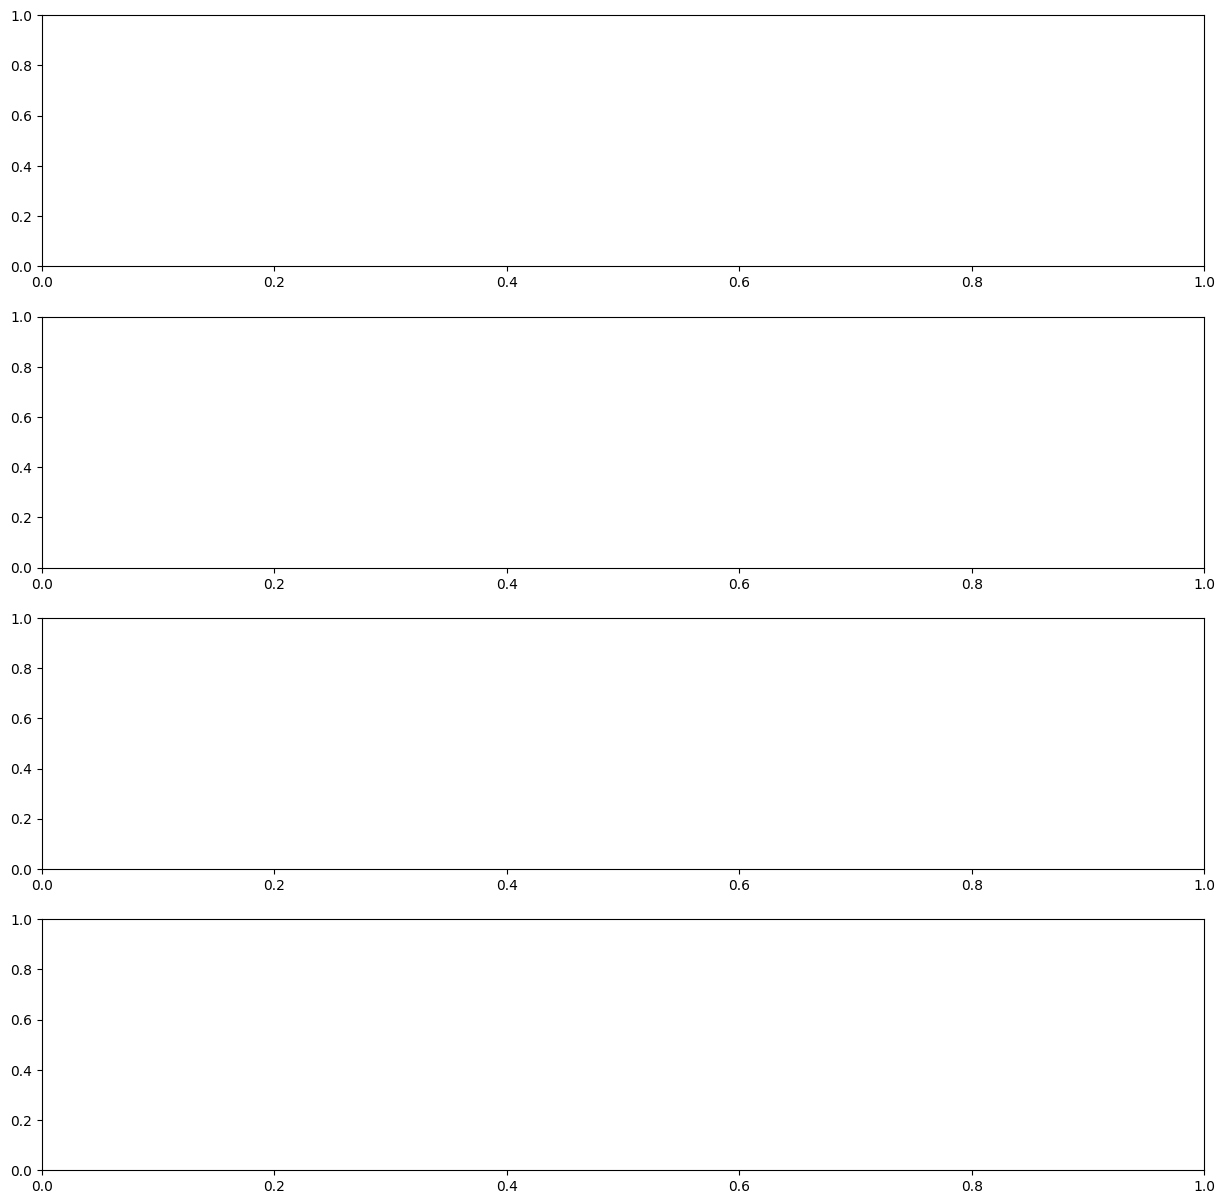

In [37]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


In [ ]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [ ]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synthetic_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



In [ ]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


In [ ]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


In [ ]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)
